<IPython.core.display.Javascript object>


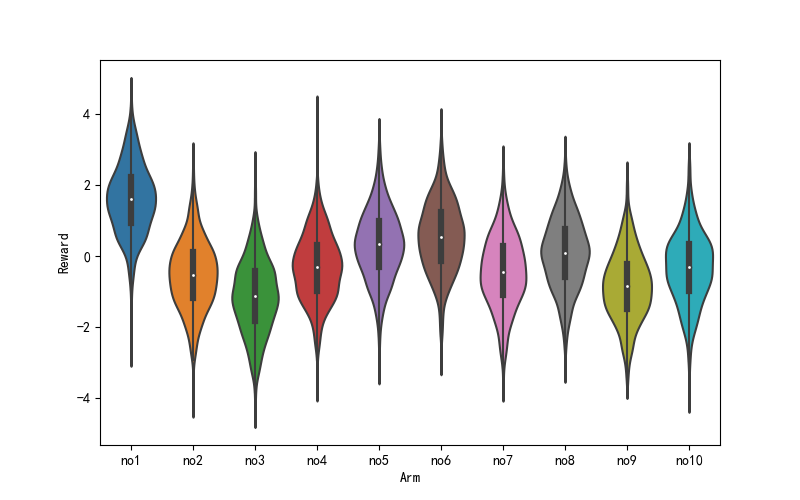

<IPython.core.display.Javascript object>


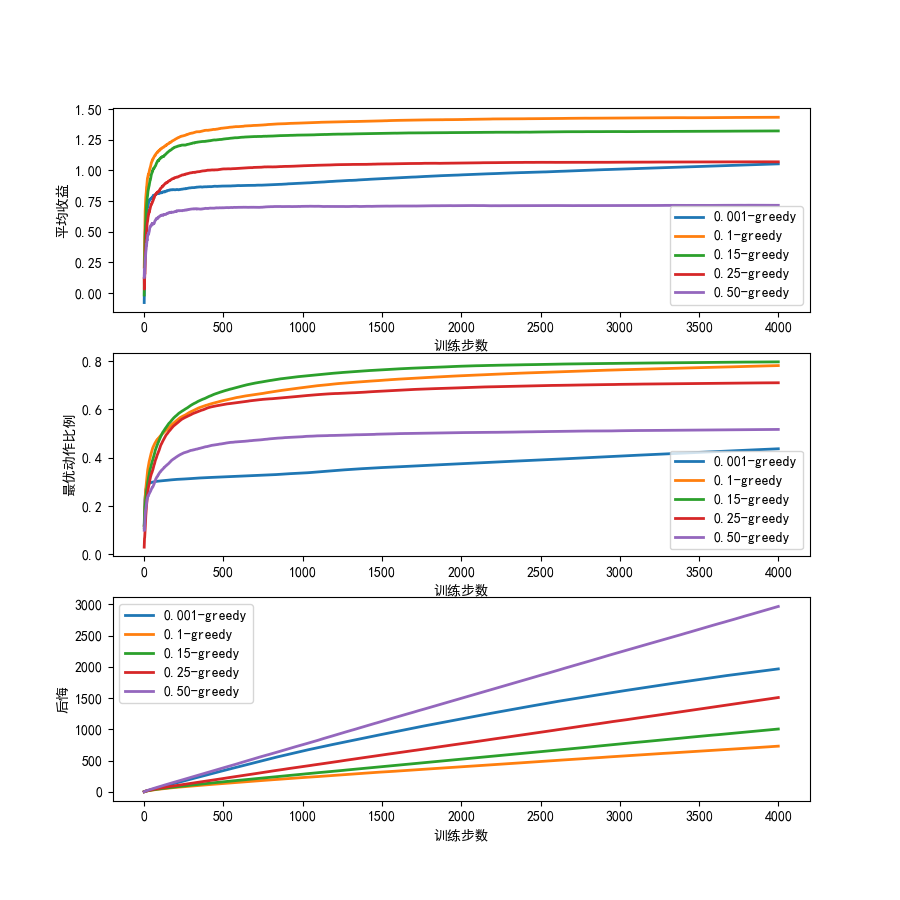

In [94]:
%matplotlib notebook
from typing import Tuple
from scipy import stats
from matplotlib.ticker import MultipleLocator
import numpy as np
import matplotlib.pyplot as plt
from abc import ABCMeta
import abc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

class GaussBandit:
    """ K臂老虎机, 每个拉杆期望收益采样自标准正态分布, 即时 reward 是收益期望加上高斯噪声 """
    def __init__(self, K=10):
        self.K = K                                # 摇臂数量
        self.values = np.random.randn(K)          # 从标准正态分布采样K个拉杆的收益均值
        self.bestAction = np.argmax(self.values)  # 最优动作索引
    
    def step(self, k):
        return np.random.normal(loc=self.values[k], scale=1, size=1) 

    def showDistribution(self):
        fig = plt.figure(figsize=(8,5))
       
        foo = pd.DataFrame(columns =['Arm','Reward'])
        for i in range(10):
            foo.loc[i] = ['no'+str(i+1),np.random.normal(loc=self.values[i], scale=1, size=1000)]
            
        foo = foo.explode('Reward')
        foo['Reward'] = foo['Reward'].astype('float')
        sns.violinplot(data=foo, x='Arm', y='Reward')

        #plt.show()

class Solver(metaclass=ABCMeta):
    """ 多臂老虎机算法基本框架 """
    def __init__(self, bandit, initValues):
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.K)  # 每根拉杆的尝试次数
        self.initValues = initValues
        self.qValues = initValues              # 当前价值估计

    @abc.abstractmethod
    def run_one_step(self) -> Tuple[int, float]:
        # 返回当前动作选择的拉杆索引以及即时reward, 由每个具体的策略实现
        pass

    def rollout(self,num_steps):
        # 运行 num_steps 次
        G, B, R = 0,0,0     # 当前收益, 当前最优选择次数, 当前步的累积懊悔

        returnCurve = np.zeros(num_steps)       # 收益曲线
        proportionCurve = np.zeros(num_steps)   # 比例曲线
        regretCurve = np.zeros(num_steps)       # 后悔曲线
        
        self.counts = np.zeros(self.bandit.K)   # 计数清零
        self.qValues = self.initValues          # 初始化价值估计

        for i in range(num_steps):
            k, r = self.run_one_step()
            self.counts[k] += 1
            self.qValues[k] += 1. / (self.counts[k]) * (r - self.qValues[k])
            
            B += (k == self.bandit.bestAction)
            G += r
            R += self.bandit.values[self.bandit.bestAction] - self.bandit.values[k]
            
            returnCurve[i] = G/(i+1)
            proportionCurve[i] = B/(i+1)
            regretCurve[i] = R
            
        return returnCurve, proportionCurve, regretCurve

class EpsilonGreedy(Solver):
    """ epsilon贪婪算法,继承Solver类 """
    def __init__(self, *args):
        bandit, initValues, epsilon = args
        super(EpsilonGreedy, self).__init__(bandit, initValues)
        self.epsilon = epsilon

    def run_one_step(self):
        if np.random.binomial(1,self.epsilon) == 1:
            k = np.random.randint(self.bandit.K)  # 随机选择一根拉杆
        else:
            k = np.random.choice([a for a in range(self.bandit.K) if self.qValues[a] == np.max(self.qValues)])
        r = self.bandit.step(k)                      # 得到本次动作的奖励
        return k, r
    
def plot(banditParas, sloverParas):
    banditClass, banditArms, banditNum, banditSteps = banditParas
    sloverClass, initValues, sloverSettings = sloverParas
    
    # 解决 plt 中文显示的问题
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    fig = plt.figure(figsize=(9,9))
    a1 = fig.add_subplot(3,1,1,label='a1')
    a2 = fig.add_subplot(3,1,2,label='a2')
    a3 = fig.add_subplot(3,1,3,label='a3')

    a1.set_xlabel('训练步数')
    a1.set_ylabel('平均收益')
    a2.set_xlabel('训练步数')
    a2.set_ylabel('最优动作比例')
    a3.set_xlabel('训练步数')
    a3.set_ylabel('后悔')
    
    # 测试三种策略
    for setting in sloverSettings:
        paraLabel = setting[0]
        
        # 实例化 Num 个赌博机
        aveRCurve, avePCurve, aveRegCurve = np.zeros(banditSteps), np.zeros(banditSteps), np.zeros(banditSteps)
        for i in range(banditNum):
            bandit = banditClass(banditArms)
            solver = sloverClass(*(bandit,initValues)+setting[1:])
            
            returnCurve, proportionCurve, regretCurve = solver.rollout(banditSteps)
            
            aveRCurve += 1/(i+1)*(returnCurve-aveRCurve)        # 增量式计算均值
            avePCurve += 1/(i+1)*(proportionCurve-avePCurve)    # 增量式计算均值
            aveRegCurve += 1/(i+1)*(regretCurve-aveRegCurve)    # 增量式计算均值

        a1.plot(aveRCurve,'-',linewidth=2, label=paraLabel)
        a2.plot(avePCurve,'-',linewidth=2, label=paraLabel)
        a3.plot(aveRegCurve,'-',linewidth=2, label=paraLabel)
        
    
    a1.legend(fontsize=10)  # 显示图例，即每条线对应 label 中的内容
    a2.legend(fontsize=10)  
    a3.legend(fontsize=10) 

    plt.show()  


if __name__ == '__main__':
    K = 10            # 摇臂数
    NUM = 100         # 赌博机数量
    STEPS = 4000      # 交互次数
    
    banditParas = (GaussBandit, K, NUM, STEPS)
    sloverSettings = [('0.001-greedy', 0.001), ('0.1-greedy',0.1), ('0.15-greedy',0.15), ('0.25-greedy',0.25), ('0.50-greedy',0.50)]
    sloverParas = (EpsilonGreedy, np.ones(K), sloverSettings)
    
    # 随机生成一个老虎机，查看拉杆收益分布
    bandit = GaussBandit(K)
    bandit.showDistribution()
    
    # 根据参数列表进行对比试验
    plot(banditParas, sloverParas)


In [95]:
def plotRegret(banditParas, sloverParas):
    banditClass, banditArms, banditNum, banditSteps = banditParas
    sloverClass, initValues, sloverSettings = sloverParas
    
    # 解决 plt 中文显示的问题
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    fig = plt.figure(figsize=(10,5))
    a1 = fig.add_subplot(1,1,1,label='a1')
    a1.set_xlabel('训练步数')
    a1.set_ylabel('后悔')
    
    # 测试三种策略
    for setting in sloverSettings:
        paraLabel = setting[0]
        
        # 实例化 Num 个赌博机
        aveRegCurve = np.zeros(banditSteps)
        for i in range(banditNum):
            bandit = banditClass(banditArms)
            solver = sloverClass(*(bandit,initValues)+setting[1:])
            
            _, _, regretCurve = solver.rollout(banditSteps)
            aveRegCurve += 1.0/(i+1)*(regretCurve-aveRegCurve)    # 增量式计算均值

        a1.plot(aveRegCurve,'-',linewidth=2, label=paraLabel)    
    a1.legend(fontsize=10)  # 显示图例，即每条线对应 label 中的内容

    plt.show()  

<IPython.core.display.Javascript object>


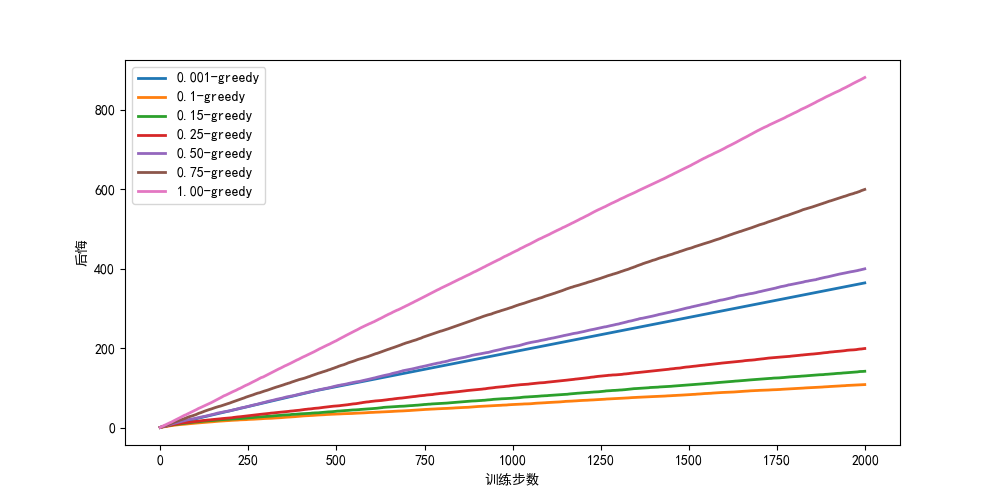

In [96]:
class BernoulliBandit:
    """ 伯努利多臂老虎机, 每个拉杆有p的概率 reward=1，1-p 概率 reward=0，p 从0-1均匀分布采样 """
    def __init__(self, K):
        self.values = np.random.uniform(size=K)   # 随机生成K个0～1的数,作为拉动每根拉杆的获奖
        self.bestAction = np.argmax(self.values)  # 获奖概率最大的拉杆
        self.K = K

    def step(self, k):
        return np.random.rand() < self.values[k]  # python 中 True/False 等价于 1/0
    
if __name__ == '__main__':
    K = 10            # 摇臂数
    NUM = 10          # 赌博机数量
    STEPS = 2000      # 交互次数
    
    np.random.seed(0)
    banditParas = (BernoulliBandit, K, NUM, STEPS)
    sloverSettings = [('0.001-greedy', 0.001), ('0.1-greedy',0.1), ('0.15-greedy',0.15), ('0.25-greedy',0.25), ('0.50-greedy',0.50), ('0.75-greedy',0.75), ('1.00-greedy',1.00)]
    sloverParas = (EpsilonGreedy, np.ones(K), sloverSettings)

    plotRegret(banditParas, sloverParas)
    
    

<IPython.core.display.Javascript object>


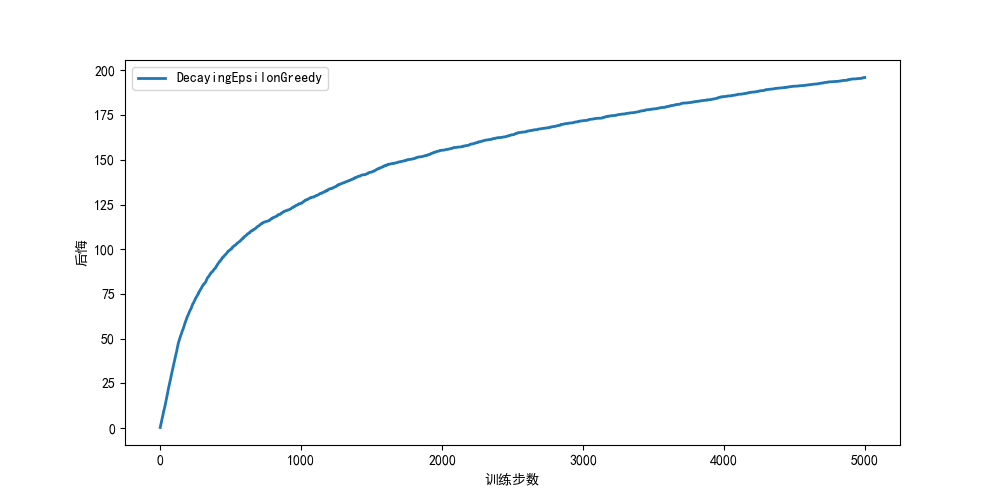

In [97]:
class DecayingEpsilonGreedy(Solver):
    """ epsilon值随时间衰减的epsilon-贪婪算法,继承Solver类 """
    def __init__(self, *args):
        bandit, initValues = args
        super(DecayingEpsilonGreedy, self).__init__(bandit, initValues)
        self.total_count = 0

    def run_one_step(self):
        self.total_count += 1
        if np.random.random() < 100 / self.total_count:  # 试探概率（epsilon）值随时间衰减，这里分子可以设置超过 1 来增强随机探索
            k = np.random.randint(0, self.bandit.K)
        else:
            k = np.random.choice([a for a in range(self.bandit.K) if self.qValues[a] == np.max(self.qValues)])

        r = self.bandit.step(k)
        return k, r    

if __name__ == '__main__':
    K = 10            # 摇臂数
    NUM = 10          # 赌博机数量
    STEPS = 5000      # 交互次数
    
    #np.random.seed(0)
    banditParas = (BernoulliBandit, K, NUM, STEPS)
    sloverParas = (DecayingEpsilonGreedy, np.ones(K), [('DecayingEpsilonGreedy',)])
   
    plotRegret(banditParas, sloverParas)
    

<IPython.core.display.Javascript object>


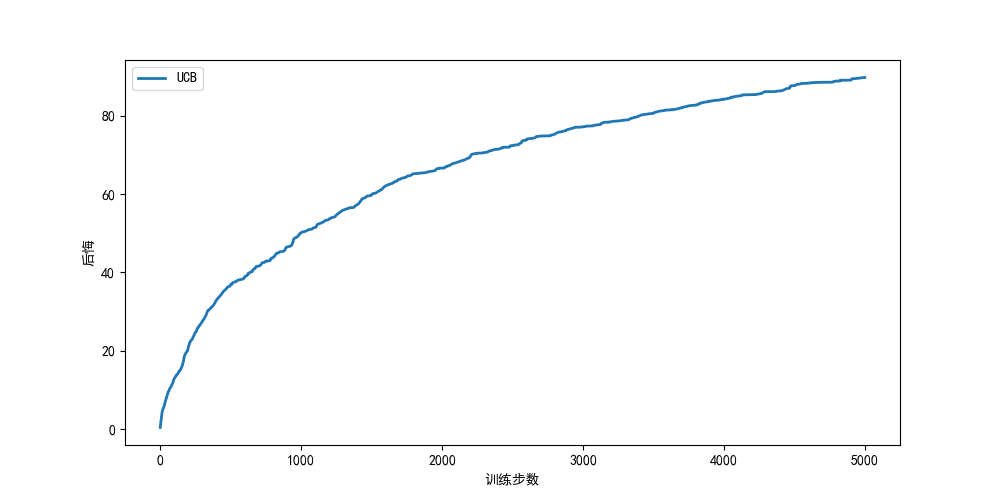

In [99]:
class UCB(Solver):
    """ UCB算法,继承Solver类 """
    def __init__(self, *args):
        bandit, initValues, coef = args
        super(UCB, self).__init__(bandit, initValues)
        self.total_count = 0
        self.coef = coef

    def run_one_step(self):
        self.total_count += 1
        ucb = self.qValues + self.coef * np.sqrt(np.log(self.total_count) / (2 * (self.counts + 1)))  # 计算上置信界
        k = np.argmax(ucb)  # 选出上置信界最大的拉杆
        r = self.bandit.step(k)
        return k, r


if __name__ == '__main__':
    K = 10            # 摇臂数
    NUM = 10          # 赌博机数量
    STEPS = 5000      # 交互次数
    
    #np.random.seed(0)
    banditParas = (BernoulliBandit, K, NUM, STEPS)
    sloverParas = (UCB, np.ones(K), [('UCB',1)])
   
    plotRegret(banditParas, sloverParas)

<IPython.core.display.Javascript object>


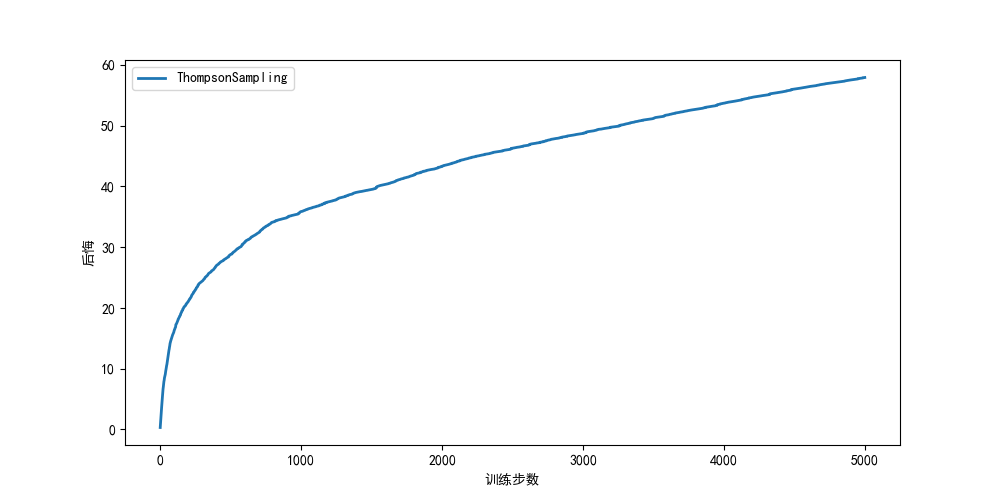

In [100]:
class ThompsonSampling(Solver):
    """ 汤普森采样算法,继承Solver类 """
    def __init__(self, *args):
        bandit, initValues = args
        super(ThompsonSampling, self).__init__(bandit, initValues) # 这里 initValues 其实没用
        self._a = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为1的次数
        self._b = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为0的次数

    def run_one_step(self):
        samples = np.random.beta(self._a, self._b)  # 按照Beta分布采样一组奖励样本
        k = np.argmax(samples)  # 选出采样奖励最大的拉杆
        r = self.bandit.step(k)

        self._a[k] += r  # 更新Beta分布的第一个参数
        self._b[k] += (1 - r)  # 更新Beta分布的第二个参数
        return k, r
    
if __name__ == '__main__':
    K = 10            # 摇臂数
    NUM = 10          # 赌博机数量
    STEPS = 5000      # 交互次数
    
    #np.random.seed(0)
    banditParas = (BernoulliBandit, K, NUM, STEPS)
    sloverParas = (ThompsonSampling, np.ones(K), [('ThompsonSampling',)])
   
    plotRegret(banditParas, sloverParas)